# 2023 전력사용량 예측 AI 경진대회

In [15]:
# 라이브러리 호출
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tcn import TCN

## 데이터 전처리

In [16]:
building_info = pd.read_csv('train_dataset/building_info.csv')
train = pd.read_csv('train_dataset/train.csv')

In [17]:
building_info

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [18]:
train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


In [19]:
train['num_date_time'] = [int(train.loc[i, 'num_date_time'][-2:]) for i in range(len(train))]

In [20]:
train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,2,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,3,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,4,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


In [21]:
train.drop(labels='일시', axis=1, inplace=True)

In [22]:
train.columns = ['time(hr)', 'building_num', 'Temperature', 'rain(mm)', 'wind(m/s)', 'humidity(%)', 'sunshine(hr)', 'insolation(hr)', 'electricity(kwh)']

In [23]:
train.drop(labels='rain(mm)', axis=1, inplace=True)
train.drop(labels='sunshine(hr)', axis=1, inplace=True)
train.drop(labels='insolation(hr)', axis=1, inplace=True)

In [24]:
train.dropna(inplace=True)

In [25]:
train

,time(hr),building_num,Temperature,wind(m/s),humidity(%),electricity(kwh)
0,0,1,18.6,0.9,42.0,1085.28
1,1,1,18.0,1.1,45.0,1047.36
2,2,1,17.7,1.5,45.0,974.88
3,3,1,16.7,1.4,48.0,953.76
4,4,1,18.4,2.8,43.0,986.40
...,...,...,...,...,...,...
203995,19,100,23.1,0.9,86.0,881.04
203996,20,100,22.4,1.3,86.0,798.96
203997,21,100,21.3,1.0,92.0,825.12
203998,22,100,21.0,0.3,94.0,640.08


In [26]:
train

,time(hr),building_num,Temperature,wind(m/s),humidity(%),electricity(kwh)
0,0,1,18.6,0.9,42.0,1085.28
1,1,1,18.0,1.1,45.0,1047.36
2,2,1,17.7,1.5,45.0,974.88
3,3,1,16.7,1.4,48.0,953.76
4,4,1,18.4,2.8,43.0,986.40
...,...,...,...,...,...,...
203995,19,100,23.1,0.9,86.0,881.04
203996,20,100,22.4,1.3,86.0,798.96
203997,21,100,21.3,1.0,92.0,825.12
203998,22,100,21.0,0.3,94.0,640.08


### 각 특성 간의 상관관계 파악

In [27]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(train.corr(), annot=True, ax=ax)

# plt.title('train data relation')
# plt.show()

<AxesSubplot: >

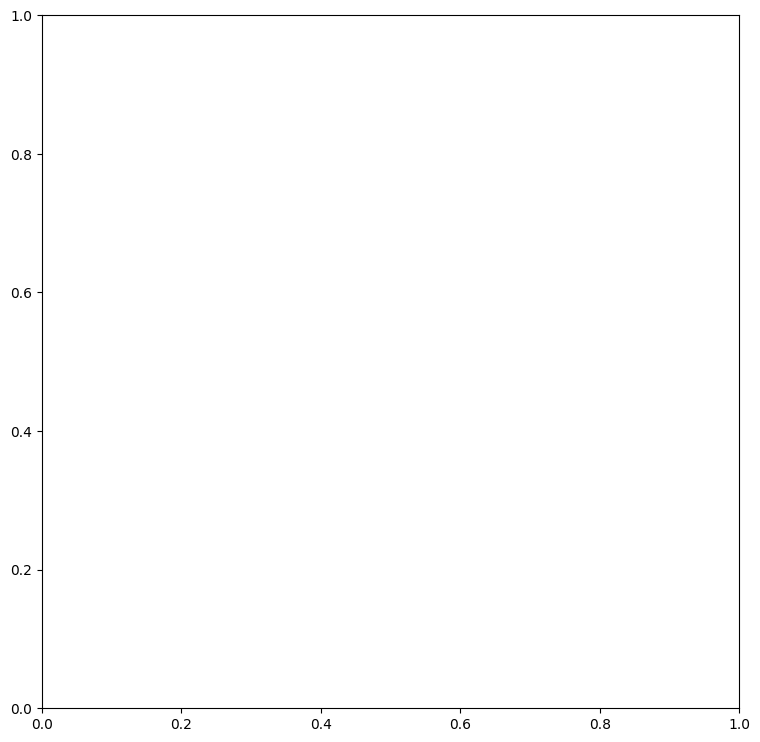

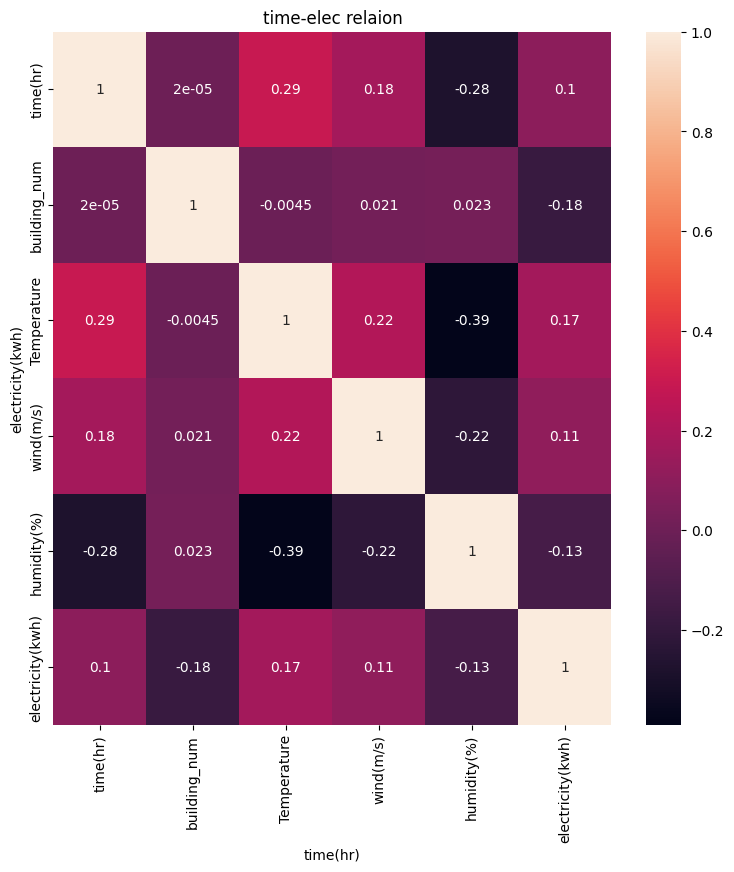

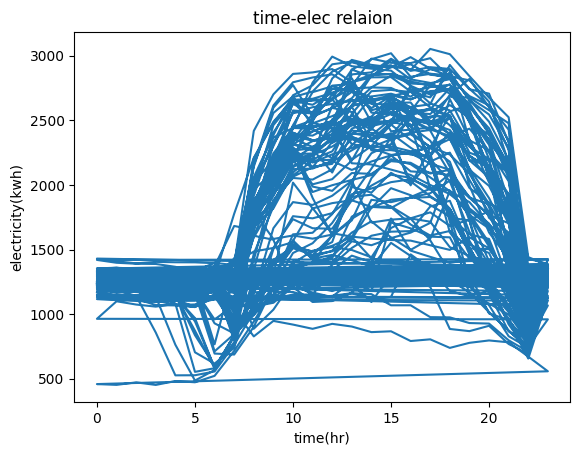

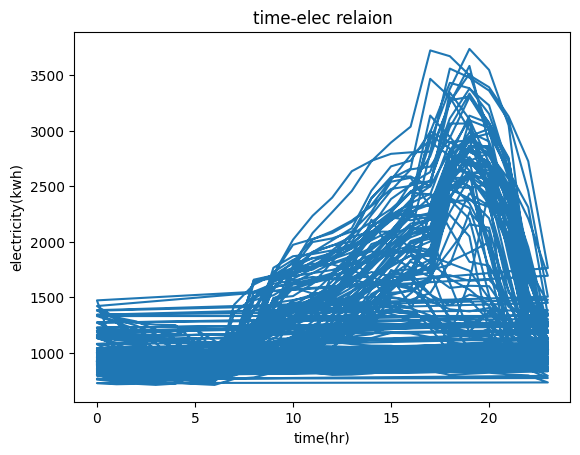

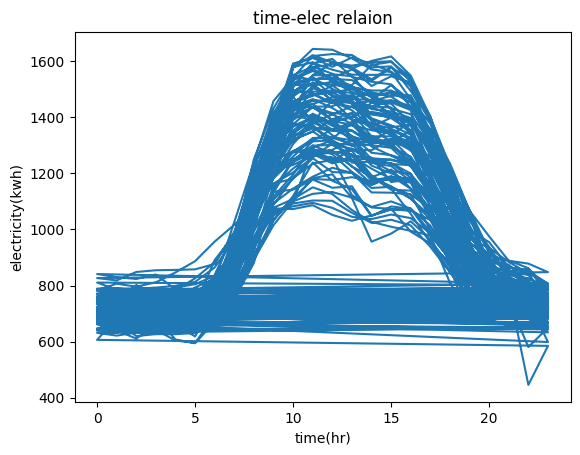

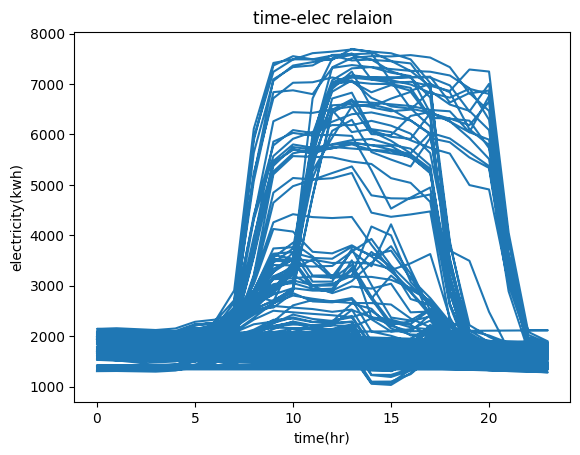

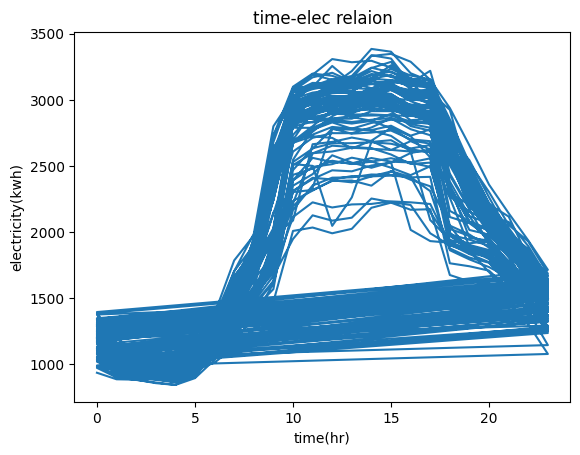

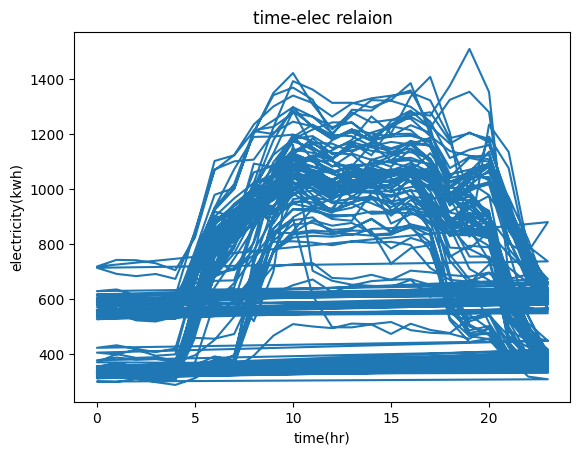

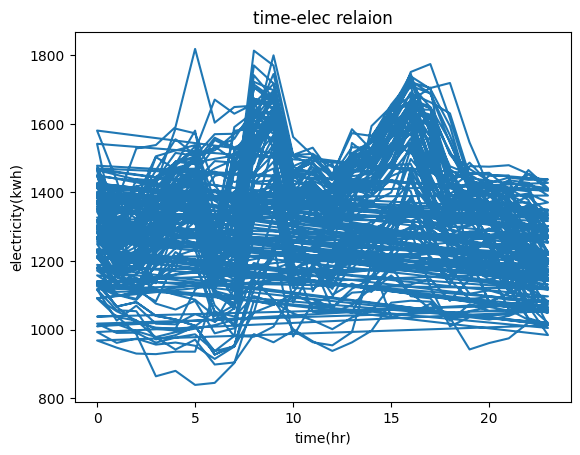

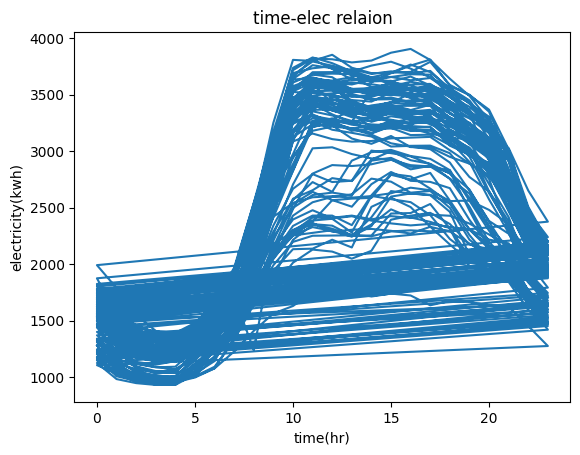

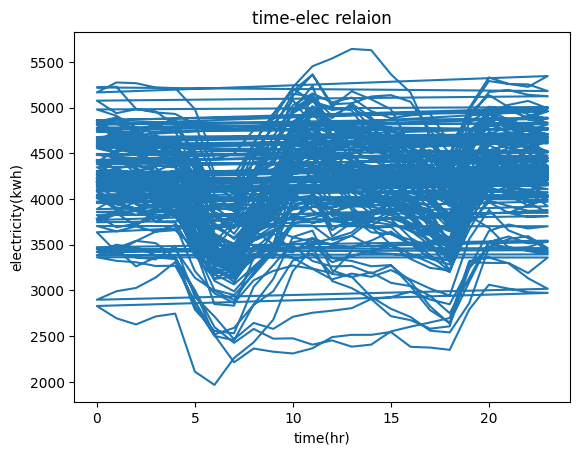

In [28]:
for i in range(1, 11):
    plt.plot(train[train['building_num']==i]['time(hr)'], train[train['building_num']==i]['electricity(kwh)'])
    plt.xlabel('time(hr)')
    plt.ylabel('electricity(kwh)')
    plt.title('time-elec relaion')
    plt.show()

### window 처리
- https://blog.naver.com/sunghyeon98/222459222648

In [31]:
class windowGenerator():
    def __init__(self, input_width, label_width, offset, train_df, val_df, test_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # window를 다루는 변수
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset

        self.total_window_size = input_width + offset

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, dataset):
        inputs = dataset[:, self.input_slice, :]
        labels = dataset[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1
            )


### 학습, 검증 데이터 분리

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train[['time(hr)', 'building_num', 'wind(m/s)', 'Temperature', 'humidity(%)', 'PrevElec']], train['electricity(kwh)'], test_size=0.3)

In [ ]:
train_x

,time(hr),building_num,wind(m/s),Temperature,humidity(%),PrevElec
71384,8,35,3.9,23.8,66.0,2115.00
4506,18,3,1.3,25.0,75.0,3138.12
144591,15,71,2.5,28.8,79.0,1912.56
156694,22,77,3.6,27.2,99.0,1347.84
29861,5,15,1.0,26.1,85.0,1551.33
...,...,...,...,...,...,...
40834,10,21,0.7,21.4,39.0,2652.02
93430,22,46,0.9,29.8,77.0,2242.08
194051,11,96,1.9,23.8,70.0,2968.20
185004,12,91,1.4,33.3,68.0,2549.28


## 모델 설계

In [ ]:
print(len(train_x.dropna()))
print(len(train_x), len(train_y), len(test_x), len(test_y))

142786
142786 142786 61194 61194


In [ ]:
train_x.isnull().any()

time(hr)        False
building_num    False
wind(m/s)       False
Temperature     False
humidity(%)     False
PrevElec        False
dtype: bool

In [ ]:
TCN_delay = [2**i for i in range(4)]

Input = tf.keras.Input(shape=(6,), name='Input')
Embed = tf.keras.layers.Embedding(input_dim=5, output_dim=20, name='Embed')(Input)
TCN_layer = TCN(nb_filters=64, kernel_size=3, padding='causal', name='TCN', dropout_rate=0.1)(Embed)
dense4 = tf.keras.layers.Dense(units=1, activation='sigmoid')(TCN_layer)
DenseModel = tf.keras.Model(inputs=[Input], outputs=dense4, name='DenseModel')

In [ ]:
DenseModel.compile(optimizer='adam', loss='mae')
StpCp = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = DenseModel.fit(train_x, train_y, epochs=1, validation_data=(test_x, test_y))

4463/4463 [==============================] - 142s 30ms/step - loss: 2449.2676 - val_loss: 2451.9297


In [ ]:
DenseModel.evaluate(test_x, test_y)

1913/1913 [==============================] - 17s 9ms/step - loss: 2451.9297


2451.9296875

## 결과 파일 도출

In [ ]:
test = pd.read_csv('test/test.csv')
test['date'] = test['num_date_time']
test['num_date_time'] = [int(test.loc[i, 'num_date_time'][-2:]) for i in range(len(test))]
test.drop(labels='일시', axis=1, inplace=True)
test.columns = ['time(hr)', 'building_num', 'Temperature', 'rain(mm)', 'wind(m/s)', 'humidity(%)', 'num_date_time']
test.drop(labels='rain(mm)', axis=1, inplace=True)
test


,time(hr),building_num,Temperature,wind(m/s),humidity(%),num_date_time
0,0,1,23.5,2.2,72,1_20220825 00
1,1,1,23.0,0.9,72,1_20220825 01
2,2,1,22.7,1.5,75,1_20220825 02
3,3,1,22.1,1.3,78,1_20220825 03
4,4,1,21.8,1.0,77,1_20220825 04
...,...,...,...,...,...,...
16795,19,100,22.5,0.9,84,100_20220831 19
16796,20,100,20.7,0.4,95,100_20220831 20
16797,21,100,20.2,0.4,98,100_20220831 21
16798,22,100,20.1,1.1,97,100_20220831 22


In [ ]:
for i in range(len(test)):
    DenseModel.predict()

time(hr)
building_num
Temperature
wind(m/s)
humidity(%)
num_date_time
